## General info:

Data from [MTA](http://web.mta.info/developers/turnstile.html) <br>
Description of data [here](http://web.mta.info/developers/resources/nyct/turnstile/ts_Field_Description.txt)


[GitHub for this project](https://github.com/huge-reality/MTA_Project_Group_5)



## Steps undertaken in this notebook
1. Read one week's worth of data, clean up column names
2. Add datetime elaborated info
3. Mask to only look at two times (8 AM and 12 PM to start)
4. Make two diff columns, entries and exits
    - Group by 'UNIT' and 'SCP'
5. Combine the entry and exit columns because they represent total traffic
    - We don't care if people are coming or going, just that they're there
6. Brute force clean up the difference data
7. Make a new dataframe that aggregates a groupby based on 'STATION'
    - The sum of the entry/exit 
8. REPEAT THE ABOVE STEPS 1-7 for 12PM - 4PM and 4PM - 8 PM
9. Make a new dataframe that has the total entries/exits for AM, midday, and PM
10. Two new columns: 1. Subtract midday from AM and 2. Subtract midday from PM
11. Filter that new dataframe to *only* include values that are high for both am vs. midday and pm vs. midday

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
pd.set_option('display.float_format', lambda x: '%.f' % x)

In [2]:
# read the data and remove spaces from column names
df1 = pd.read_csv('http://web.mta.info/developers/data/nyct/turnstile/turnstile_190427.txt')
df2 = pd.read_csv('http://web.mta.info/developers/data/nyct/turnstile/turnstile_190504.txt')
df3 = pd.read_csv('http://web.mta.info/developers/data/nyct/turnstile/turnstile_190511.txt')

am = df1.append([df2, df3])

am.columns = am.columns.str.strip()


# add in two new columns, one that is a datetime (from the date and time columns)
# and one that is just the day of the week
am['DATETIME'] = am['DATE'] + ' ' + am['TIME']
am['DATETIME'] = pd.to_datetime(am['DATETIME'], format="%m/%d/%Y %H:%M:%S")
am['DAY'] = am['DATETIME'].dt.day_name()

# only look at M-F and the 8AM - 12PM 
am = am[(am["TIME"] == '08:00:00') | (am["TIME"] == '12:00:00')]
am = am[(am["DAY"] != 'Saturday') & (am["DAY"] != 'Sunday')]


# make three new columns:
# 1. the difference between the number of entries of the row and the row above it
# 2. same for exits
# 3. a new column that is the sum of the first two, divided by the length to normalize

am['exits_diff'] = am.groupby(['SCP'])['EXITS'].transform(lambda x: x.diff())
am['entries_diff'] = am.groupby(['SCP'])['ENTRIES'].transform(lambda x: x.diff())
am['am_diff'] = am['entries_diff'] + am['exits_diff']
am['am_diff'] = am['am_diff']


# remove all diff values that are negative and 
# remove all diff values that are greater than 30k
# 30k is an estimation of how many people could realistically go through a turnstile
# in a 4h period

am = am[(am['am_diff'] > 0)] 
am = am[(am['am_diff'] < 15000)] 
print(am['am_diff'].describe())


# make a new dataframe that has the aggregate sum of 
# entry/exit differences for each station/unit pair
# make a new index column
# print the result
am_agg = am.groupby(['STATION']).agg({'am_diff' : 'sum'})
am_agg.reset_index(inplace=True)
am_agg.head(20)

count   60856
mean     1215
std      1139
min         1
25%       445
50%       847
75%      1645
max     13518
Name: am_diff, dtype: float64


,STATION,am_diff
0,1 AV,498145
1,103 ST-CORONA,430828
2,104 ST,69899
3,110 ST,252679
4,111 ST,240946
5,121 ST,58551
6,125 ST,906004
7,135 ST,263364
8,138/GRAND CONC,82883
9,14 ST,935794


In [3]:
# read the data and remove spaces from column names
df1 = pd.read_csv('http://web.mta.info/developers/data/nyct/turnstile/turnstile_190427.txt')
df2 = pd.read_csv('http://web.mta.info/developers/data/nyct/turnstile/turnstile_190504.txt')
df3 = pd.read_csv('http://web.mta.info/developers/data/nyct/turnstile/turnstile_190511.txt')

mid = df1.append([df2, df3])

mid.columns = mid.columns.str.strip()


# add in two new columns, one that is a datetime (from the date and time columns)
# and one that is just the day of the week
mid['DATETIME'] = mid['DATE'] + ' ' + mid['TIME']
mid['DATETIME'] = pd.to_datetime(mid['DATETIME'], format="%m/%d/%Y %H:%M:%S")
mid['DAY'] = mid['DATETIME'].dt.day_name()

# only look at M-F and the 8AM - 12PM 
mid = mid[(mid["TIME"] == '12:00:00') | (mid["TIME"] == '16:00:00')]
mid = mid[(mid["DAY"] != 'Saturday') & (mid["DAY"] != 'Sunday')]

# make three new columns:
# 1. the difference between the number of entries of the row and the row above it
# 2. same for exits
# 3. a new column that is the sum of the first two , divided by the length to normalize

mid['exits_diff'] = mid.groupby(['SCP'])['EXITS'].transform(lambda x: x.diff())
mid['entries_diff'] = mid.groupby(['SCP'])['ENTRIES'].transform(lambda x: x.diff())
mid['mid_diff'] = mid['entries_diff'] + mid['exits_diff']
mid['mid_diff'] = mid['mid_diff']



# remove all diff values that are negative and 
# remove all diff values that are greater than 30k
# 30k is an estimation of how many people could realistically go through a turnstile
# in a 4h period

mid = mid[(mid['mid_diff'] > 0)] 
mid = mid[(mid['mid_diff'] < 15000)] 
print(mid['mid_diff'].describe())


# make a new dataframe that has the aggregate sum of 
# entry/exit differences for each station/unit pair
# make a new index column
# print the result
mid_agg = mid.groupby(['STATION']).agg({'mid_diff' : 'sum'})
mid_agg.reset_index(inplace=True)
mid_agg.head(20)

count   60825
mean     1201
std      1263
min         1
25%       354
50%       717
75%      1652
max     14984
Name: mid_diff, dtype: float64


,STATION,mid_diff
0,1 AV,495875
1,103 ST-CORONA,427942
2,104 ST,68654
3,110 ST,251602
4,111 ST,239131
5,121 ST,58167
6,125 ST,905427
7,135 ST,261286
8,138/GRAND CONC,83177
9,14 ST,932249


In [4]:
# read the data and remove spaces from column names
df1 = pd.read_csv('http://web.mta.info/developers/data/nyct/turnstile/turnstile_190427.txt')
df2 = pd.read_csv('http://web.mta.info/developers/data/nyct/turnstile/turnstile_190504.txt')
df3 = pd.read_csv('http://web.mta.info/developers/data/nyct/turnstile/turnstile_190511.txt')

pm = df1.append([df2, df3])
pm.columns = pm.columns.str.strip()


# add in two new columns, one that is a datetime (from the date and time columns)
# and one that is just the day of the week
pm['DATETIME'] = pm['DATE'] + ' ' + pm['TIME']
pm['DATETIME'] = pd.to_datetime(pm['DATETIME'], format="%m/%d/%Y %H:%M:%S")
pm['DAY'] = pm['DATETIME'].dt.day_name()

# only look at M-F and the 4PM - 8PM 
pm = pm[(pm["TIME"] == '16:00:00') | (pm["TIME"] == '20:00:00')]
pm = pm[(pm["DAY"] != 'Saturday') & (pm["DAY"] != 'Sunday')]

# make three new columns:
# 1. the difference between the number of entries of the row and the row above it
# 2. same for exits
# 3. a new column that is the sum of the first two, divided by the length to normalize

pm['exits_diff_pm'] = pm.groupby(['SCP'])['EXITS'].transform(lambda x: x.diff())
pm['entries_diff_pm'] = pm.groupby(['SCP'])['ENTRIES'].transform(lambda x: x.diff())
pm['pm_diff'] = pm['entries_diff_pm'] + pm['exits_diff_pm']
pm['pm_diff'] = pm['pm_diff']


# remove all diff values that are negative and 
# remove all diff values that are greater than 30k
# 30k is an estimation of how many people could realistically go through a turnstile
# in a 4h period

pm = pm[(pm['pm_diff'] > 0)] 
pm = pm[(pm['pm_diff'] < 15000)] 
print(pm['pm_diff'].describe())


# make a new dataframe that has the aggregate sum of 
# entry/exit differences for each station/unit pair
# make a new index column
# print the result
pm_agg = pm.groupby(['STATION']).agg({'pm_diff' : 'sum'})
pm_agg.reset_index(inplace=True)
pm_agg.head(20)

count   60733
mean     1231
std      1054
min         1
25%       488
50%       946
75%      1672
max     13838
Name: pm_diff, dtype: float64


,STATION,pm_diff
0,1 AV,511285
1,103 ST-CORONA,435827
2,104 ST,70468
3,110 ST,254919
4,111 ST,242645
5,121 ST,59196
6,125 ST,908692
7,135 ST,264595
8,138/GRAND CONC,83642
9,14 ST,964366


In [5]:
# make a new df by copying the am aggregate df
final = am_agg
print(final.head())

# add two new columns to include the mid-day and evening commute
# diff values
final['mid_diff'] = mid_agg['mid_diff'].values
final['pm_diff'] = pm_agg['pm_diff'].values

# make two new columns comparing the mid-day traffic to
# both the morning and the evening
final['am_v_mid'] = final['am_diff'] - final['mid_diff']
final['pm_v_mid'] = final['pm_diff'] - final['mid_diff']

# sort the df by  one of the important columns (am chosen here arbitrarily)
# and print the info to see how many rows
final.sort_values('mid_diff', ascending=False, inplace = True)

print(final.info())
final.head()

# get rid of all values where either evaluation is low, aribtrarily chosen
# to be 1,000 here

final = final[(final['am_v_mid'] > 1000) & (final['pm_v_mid'] > 1000)]
print(final.info())
final.head(20)

         STATION  am_diff
0           1 AV   498145
1  103 ST-CORONA   430828
2         104 ST    69899
3         110 ST   252679
4         111 ST   240946
<class 'pandas.core.frame.DataFrame'>
Int64Index: 211 entries, 41 to 90
Data columns (total 6 columns):
STATION     211 non-null object
am_diff     211 non-null float64
mid_diff    211 non-null float64
pm_diff     211 non-null float64
am_v_mid    211 non-null float64
pm_v_mid    211 non-null float64
dtypes: float64(5), object(1)
memory usage: 11.5+ KB
None
<class 'pandas.core.frame.DataFrame'>
Int64Index: 112 entries, 41 to 164
Data columns (total 6 columns):
STATION     112 non-null object
am_diff     112 non-null float64
mid_diff    112 non-null float64
pm_diff     112 non-null float64
am_v_mid    112 non-null float64
pm_v_mid    112 non-null float64
dtypes: float64(5), object(1)
memory usage: 6.1+ KB
None


,STATION,am_diff,mid_diff,pm_diff,am_v_mid,pm_v_mid
41,34 ST-PENN STA,3112079,3073792,3171676,38287,97884
39,34 ST-HERALD SQ,2964158,2932851,3041917,31307,109066
198,TIMES SQ-42 ST,2559411,2529471,2620876,29940,91405
60,59 ST COLUMBUS,1846077,1841308,1872939,4769,31631
142,GRD CNTRL-42 ST,1779374,1741775,1807402,37599,65627
50,47-50 STS ROCK,1689381,1640442,1701152,48939,60710
59,59 ST,1530487,1509553,1555517,20934,45964
31,23 ST,1442469,1420566,1463324,21903,42758
114,CHAMBERS ST,1410464,1398516,1423797,11948,25281
47,42 ST-PORT AUTH,1374821,1338888,1385921,35933,47033


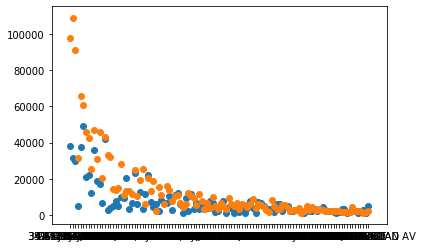

In [9]:
x = final['STATION']
y1 = final['am_v_mid']
y2 = final['pm_v_mid']
plt.scatter(x, y1)
plt.scatter(x, y2)


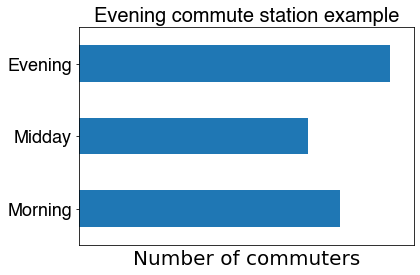

In [17]:
final.iloc[0].drop(['STATION', 'am_v_mid', 'pm_v_mid']).plot.barh()
plt.title('Evening commute station example',fontname = 'Helvetica', fontsize = 20,loc='center',  weight = 'bold');
plt.xlabel('Number of commuters',fontsize = 20);

ticks_x = np.linspace(900000, 990000, 0)
plt.xticks(ticks_x, fontsize = '10', fontname = 'Helvetica');

ticks_y = np.linspace(0, 2, 3)
months = ['Morning','Midday','Evening']
plt.yticks(ticks_y, months, fontsize = '18', fontname = 'Helvetica');


plt.xlim([2800000, 3200000]);

plt.savefig('PM_commute.png')

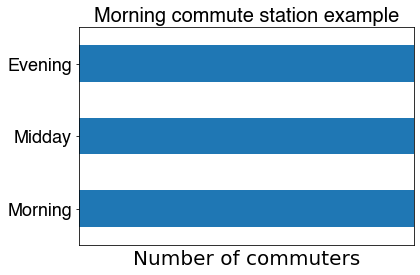

In [11]:
final.iloc[2].drop(['STATION', 'am_v_mid', 'pm_v_mid']).plot.barh()
plt.title('Morning commute station example',fontname = 'Helvetica', fontsize = 20,loc='center',  weight = 'bold');
plt.xlabel('Number of commuters',fontsize = 20);

ticks_x = np.linspace(900000, 990000, 0)
plt.xticks(ticks_x, fontsize = '10', fontname = 'Helvetica');

ticks_y = np.linspace(0, 2, 3)
months = ['Morning','Midday','Evening']
plt.yticks(ticks_y, months, fontsize = '18', fontname = 'Helvetica');


plt.xlim([1300000, 1380000]);
plt.savefig('AM_commute.png')